In [2003]:
import pandas as pd
import numpy as np
import json
import folium
from datetime import datetime, timedelta
import os
import seaborn as sns
import matplotlib.pyplot as plt

import yaml

In [2004]:
from data_cleaning.json_manipulation import load_json, trim_json_to_locations, gather_bajs_locations, get_bikes_in_stations, calculate_bike_changes, create_changes_columns, create_population_columns
from visualization.station_map import populate_map_with_stations
from visualization.individual_station_plots import plot_hourly_changes_bar, plot_weekday_bar, stringify_plot, combined_plot_daily_weekly, station_population_boxplots
from data_cleaning.data_wrangling import create_hourly_df, create_weekday_df, get_population_extremes

In [2005]:
config = yaml.safe_load(open("../config.YAML"))

In [2006]:
with open("../data/test_JSON_data/bajs_10-11-2025_15-11-31.json") as json_data:
    day_one = json.load(json_data)
    json_data.close()

In [2007]:
day_one

{'countries': [{'lat': 45.8049,
   'lng': 15.9467,
   'zoom': 10,
   'name': 'Bajs Zagreb (Croatia)',
   'hotline': '0038515494477',
   'domain': 'hd',
   'language': 'hr',
   'email': 'bajs@zagreb.hr',
   'timezone': 'Europe/Berlin',
   'currency': 'EUR',
   'country_calling_code': '+385',
   'system_operator_address': 'Sustav javnih bicikala d.o.o., Prisavlje 2, 10000 Zagreb',
   'country': 'HR',
   'country_name': 'Croatia',
   'terms': 'https://bajs.zagreb.hr/hr/uvjetikoristenja/',
   'policy': 'https://bajs.zagreb.hr/hr/pravila-privatnosti/',
   'website': 'https://bajs.zagreb.hr',
   'show_bike_types': False,
   'show_bike_type_groups': False,
   'show_free_racks': False,
   'booked_bikes': 0,
   'set_point_bikes': 2000,
   'available_bikes': 1812,
   'capped_available_bikes': False,
   'no_registration': False,
   'pricing': 'https://bajs.zagreb.hr/hr/',
   'vat': '25',
   'faq_url': 'https://bajs.zagreb.hr',
   'store_uri_android': 'https://play.google.com/store/apps/details?id

In [2008]:
trim_json_to_locations(day_one)

[{'uid': 556632908,
  'lat': 45.825299,
  'lng': 16.109747,
  'bike': False,
  'name': 'AUTOBUSNI TERMINAL SESVETE',
  'address': None,
  'spot': True,
  'number': 21200,
  'booked_bikes': 0,
  'bikes': 5,
  'bikes_available_to_rent': 5,
  'active_place': 1,
  'bike_racks': 8,
  'free_racks': 3,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800463', '800020', '801638', '801088', '801072'],
  'bike_types': {'196': 4, '409': 1},
  'place_type': '0',
  'rack_locks': False},
 {'uid': 556633495,
  'lat': 45.842797,
  'lng': 15.975421,
  'bike': False,
  'name': 'MIHALJEVAC OKRETIŠTE',
  'address': None,
  'spot': True,
  'number': 21201,
  'booked_bikes': 0,
  'bikes': 11,
  'bikes_available_to_rent': 11,
  'active_place': 1,
  'bike_racks': 12,
  'free_racks': 1,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800480',
   '800247',
   '800185',
 

In [2009]:
locations = gather_bajs_locations(trim_json_to_locations(day_one))
locations.head()

,uid,name,lat,lng,no_racks
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20


In [2010]:
locations.shape
# 165 different stations in Zagreb

(165, 5)

Thunderforest.Neighbourhood
OSMBright
Esri.WorldTopoMap
CartoDB.Voyager

In [2011]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [2012]:
circles = populate_map_with_stations(m, locations)
_ = [circ.add_to(m) for circ in circles]


In [2013]:
m

## Individual bikes at individual times

In [2014]:
first_dt = datetime.strptime("2025/11/10 15:11:31",
    "%Y/%m/%d %H:%M:%S")

first_dt

datetime.datetime(2025, 11, 10, 15, 11, 31)

In [2015]:
time1 = get_bikes_in_stations(time = first_dt,
    loc_list = trim_json_to_locations(day_one))

time1.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]"
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155..."
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]"
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099..."


In [2016]:
# For testing purposes, we'll use this data as a second timepoint even though it's been more than a day
with open("../data/test_JSON_data/bajs_12-11-2025_09-30-11.json") as json_data:
    day_two = json.load(json_data)
    json_data.close()

In [2017]:
second_dt = datetime.strptime("2025/11/10 16:30:00",
    "%Y/%m/%d %H:%M:%S")

time2 = get_bikes_in_stations(time = second_dt,
    loc_list = trim_json_to_locations(day_two))

time2.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 16:30:00,"[800479, 800463, 800282, 801088]"
1,556633495,2025-11-10 16:30:00,"[800480, 800185, 800052, 801489, 801321]"
2,556634009,2025-11-10 16:30:00,"[800274, 801882, 801360, 801296, 801022]"
3,556637365,2025-11-10 16:30:00,"[800344, 800033, 801920, 801915, 801881, 80164..."
4,556689563,2025-11-10 16:30:00,"[800485, 800329, 800233, 800230, 800223, 80019..."


In [2018]:
more_times = pd.concat([time1, time2])
# for each uid-time, what is the closest observed time before the one in this row?
more_times["lag1_time"] = more_times.groupby(["uid"])["time"].shift(1)

more_times

previous_bikes = more_times.merge(more_times.drop(["lag1_time"], axis = 1), # so we don't get this as an additional column
    how = "left",
    left_on = ["uid", "lag1_time"],
    right_on = ["uid", "time"],
    suffixes = (None, "_lag1")).drop(
        ["time_lag1"], axis = 1
    )



previous_bikes

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]",NaT,NaN
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",NaT,NaN
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]",NaT,NaN
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",NaT,NaN
...,...,...,...,...,...
326,585913527,2025-11-10 16:30:00,"[800278, 800101, 801656, 801228, 801046, 80077...",2025-11-10 15:11:31,[]
327,585913605,2025-11-10 16:30:00,"[801717, 801191, 801157, 800603, 800601, 800517]",2025-11-10 15:11:31,[801963]
328,585913702,2025-11-10 16:30:00,"[800347, 800115, 801866, 801826, 801795, 80166...",2025-11-10 15:11:31,"[800293, 800219, 800191, 800068, 801907, 80175..."
329,586256300,2025-11-10 16:30:00,"[800144, 801889, 801867, 801457, 801066, 80095...",2025-11-10 15:11:31,"[800318, 800144, 801889, 801867, 801169, 80116..."


In [2019]:
calculate_bike_changes(previous_bikes["bikes_at_station"], previous_bikes["bikes_at_station_lag1"])

{'changes': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     7.0
 328    31.0
 329     5.0
 330     5.0
 Length: 331, dtype: float64,
 'incoming': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     0.0
 327     1.0
 328    15.0
 329     3.0
 330     0.0
 Length: 331, dtype: float64,
 'outgoing': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     6.0
 328    16.0
 329     2.0
 330     5.0
 Length: 331, dtype: float64}

## Load all data from folder and calculate changes

In [2020]:
raw_files_directory = "../data/" + config["data"]["raw_json_folder"]

raw_files = os.listdir(raw_files_directory)
raw_files

['bajs_10-11-2025_15-11-31.json',
 'bajs_10-11-2025_21-02-43.json',
 'bajs_11-11-2025_09-06-29.json',
 'bajs_11-11-2025_21-09-35.json',
 'bajs_12-11-2025_09-02-54.json',
 'bajs_12-11-2025_09-30-11.json',
 'bajs_12-11-2025_21-07-14.json',
 'bajs_13-11-2025_09-01-27.json',
 'bajs_13-11-2025_21-12-30.json',
 'bajs_14-11-2025_09-14-47.json',
 'bajs_14-11-2025_21-09-47.json']

In [2021]:
raw_files[0][5:-5]

'10-11-2025_15-11-31'

In [2022]:
#TODO - extracting from first to last number instead of absolute position?

datetime.strptime(raw_files[0][5:-5], "%d-%m-%Y_%H-%M-%S")

datetime.datetime(2025, 11, 10, 15, 11, 31)

In [2023]:
scraped_datetimes = [datetime.strptime(filename[5:-5], "%d-%m-%Y_%H-%M-%S") for filename in raw_files]
scraped_datetimes

[datetime.datetime(2025, 11, 10, 15, 11, 31),
 datetime.datetime(2025, 11, 10, 21, 2, 43),
 datetime.datetime(2025, 11, 11, 9, 6, 29),
 datetime.datetime(2025, 11, 11, 21, 9, 35),
 datetime.datetime(2025, 11, 12, 9, 2, 54),
 datetime.datetime(2025, 11, 12, 9, 30, 11),
 datetime.datetime(2025, 11, 12, 21, 7, 14),
 datetime.datetime(2025, 11, 13, 9, 1, 27),
 datetime.datetime(2025, 11, 13, 21, 12, 30),
 datetime.datetime(2025, 11, 14, 9, 14, 47),
 datetime.datetime(2025, 11, 14, 21, 9, 47)]

**IMPORTANT**  
The scraper times need to be adjusted up by an hour to match the local times!

In [2024]:
scraped_datetimes = [date + timedelta(hours = 1) for date in scraped_datetimes]
scraped_datetimes

[datetime.datetime(2025, 11, 10, 16, 11, 31),
 datetime.datetime(2025, 11, 10, 22, 2, 43),
 datetime.datetime(2025, 11, 11, 10, 6, 29),
 datetime.datetime(2025, 11, 11, 22, 9, 35),
 datetime.datetime(2025, 11, 12, 10, 2, 54),
 datetime.datetime(2025, 11, 12, 10, 30, 11),
 datetime.datetime(2025, 11, 12, 22, 7, 14),
 datetime.datetime(2025, 11, 13, 10, 1, 27),
 datetime.datetime(2025, 11, 13, 22, 12, 30),
 datetime.datetime(2025, 11, 14, 10, 14, 47),
 datetime.datetime(2025, 11, 14, 22, 9, 47)]

In [2025]:
data_timepoints = [
    trim_json_to_locations(load_json(raw_files_directory + "/" + json_file))
    for json_file
    in raw_files
]

len(data_timepoints)

11

In [2026]:
# Locations on most up-to-date info
locations = gather_bajs_locations(data_timepoints[-1])

In [2027]:
bike_data = None

for i in range(len(data_timepoints)):
    timepoint_bikes = get_bikes_in_stations(time = scraped_datetimes[i],
        loc_list = data_timepoints[i])

    if i == 0: 
        bike_data = timepoint_bikes
    else:
        bike_data = pd.concat([bike_data, timepoint_bikes])

bike_data

,uid,time,bikes_at_station
0,556632908,2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]"
1,556633495,2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155..."
3,556637365,2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]"
4,556689563,2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099..."
...,...,...,...
163,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113..."
164,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150..."
165,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106..."
166,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195..."


In [2028]:
bike_data = create_changes_columns(bike_data)

    # Drop the rows that have undefined changes - those belong to very first
    # datapoints, with no points before them so changes can't be calculated
    # Removing those will keep them from distorting e.g. means (they still count as n for dividing sums)
bike_data = bike_data.query("changes.notna()")
bike_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
165,556632908,2025-11-10 22:02:43,"[800463, 800020, 801638, 801088, 800886]",2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]",2.0,1.0,1.0
166,556633495,2025-11-10 22:02:43,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",2.0,0.0,2.0
167,556634009,2025-11-10 22:02:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",6.0,5.0,1.0
168,556637365,2025-11-10 22:02:43,"[800428, 800345, 801920, 801915, 801881, 80174...",2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]",16.0,14.0,2.0
169,556689563,2025-11-10 22:02:43,"[801846, 801666, 801548, 801347, 801283, 80102...",2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",9.0,4.0,5.0
...,...,...,...,...,...,...,...,...
1824,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0
1825,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0
1826,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0
1827,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0


## Total changes on map

In [2029]:
bike_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
165,556632908,2025-11-10 22:02:43,"[800463, 800020, 801638, 801088, 800886]",2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]",2.0,1.0,1.0
166,556633495,2025-11-10 22:02:43,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",2.0,0.0,2.0
167,556634009,2025-11-10 22:02:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",6.0,5.0,1.0
168,556637365,2025-11-10 22:02:43,"[800428, 800345, 801920, 801915, 801881, 80174...",2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]",16.0,14.0,2.0
169,556689563,2025-11-10 22:02:43,"[801846, 801666, 801548, 801347, 801283, 80102...",2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",9.0,4.0,5.0
...,...,...,...,...,...,...,...,...
1824,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0
1825,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0
1826,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0
1827,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0


In [2030]:
bike_data["bikes_at_station"].iloc[2]

['800220',
 '800201',
 '800129',
 '800079',
 '801995',
 '801882',
 '801644',
 '801557',
 '801528',
 '801405',
 '801344',
 '801305',
 '801267',
 '801243',
 '801022',
 '800801',
 '800717',
 '800698']

In [2031]:
locations

,uid,name,lat,lng,no_racks
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20
...,...,...,...,...,...
163,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10
164,585913702,KORANSKA UL.,45.802365,15.968013,10
165,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10
166,586273004,UL. V. VARIĆAKA 12,45.765589,15.988426,10


In [2032]:
# For each station, sum up all changes through time
# Also, weight changes by rack size

total_changes = bike_data.groupby("uid").sum(["changes"])
total_changes = total_changes.rename({"changes":"total_changes"}, axis = 1)
total_changes

,total_changes,incoming,outgoing
uid,,,
556632908,22.0,13.0,9.0
556633495,22.0,10.0,12.0
556634009,89.0,42.0,47.0
556637365,107.0,60.0,47.0
556689563,149.0,74.0,75.0
...,...,...,...
585913605,46.0,28.0,18.0
585913702,77.0,36.0,41.0
586256300,13.0,6.0,7.0


In [2033]:
locations_changes = locations.join(total_changes, on = "uid")
locations_changes["weighted_changes"] = locations_changes["total_changes"] / locations_changes["no_racks"]
locations_changes

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8,22.0,13.0,9.0,2.750000
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12,22.0,10.0,12.0,1.833333
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10,89.0,42.0,47.0,8.900000
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20,107.0,60.0,47.0,5.350000
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,149.0,74.0,75.0,7.450000
...,...,...,...,...,...,...,...,...,...
163,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10,46.0,28.0,18.0,4.600000
164,585913702,KORANSKA UL.,45.802365,15.968013,10,77.0,36.0,41.0,7.700000
165,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10,13.0,6.0,7.0,1.300000
166,586273004,UL. V. VARIĆAKA 12,45.765589,15.988426,10,49.0,34.0,15.0,4.900000


In [2034]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [2035]:
circles = populate_map_with_stations(m,
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Bike changes: ",
                               no_bins = 12)
_ = [circ.add_to(m) for circ in circles]

In [2036]:
m

We can see that the number of racks DOESN'T necessarily mean that this is the maximum amount of bikes that can be at a station at the same time. Maybe they're counted if they're in the near vicinity?  

Still, the no_racks is still useful as an approximation of how large/frequently used the station is planned to be.

### Tables of usage
Most and least used total

In [2037]:
locations_changes.sort_values("total_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
27,556723550,TRG KRALJA TOMISLAVA,45.805057,15.978300,57,512.0,283.0,229.0,8.982456
19,556702659,GREEN GOLD,45.802755,16.002169,40,360.0,166.0,194.0,9.000000
18,556702069,S.D. CVJETNO NASELJE,45.790564,15.961748,30,326.0,177.0,149.0,10.866667
59,579364165,FILOZOFSKI FAKULTET,45.796235,15.970371,20,223.0,95.0,128.0,11.150000
12,556696500,S.D. STJEPAN RADIĆ,45.784832,15.949303,20,198.0,108.0,90.0,9.900000


In [2038]:
locations_changes.sort_values("total_changes",  ascending = True).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
118,583385565,SD SUTINSKA VRELA,45.817745,15.832586,8,0.0,0.0,0.0,0.0
167,587422590,MLADOST,45.783761,15.944574,10,0.0,0.0,0.0,0.0
51,579361783,AUTOBUSNO STAJALIŠTE PRIGORNICA,45.815251,15.848368,10,4.0,1.0,3.0,0.4
156,585911812,RADNIČKA CESTA 228,45.778281,16.054742,10,5.0,3.0,2.0,0.5
72,579365873,PODSUSED OKRETIŠTE,45.815295,15.835378,5,6.0,3.0,3.0,1.2


Most used relative to number of racks provided - possibly could use more racks installed:

In [2039]:
locations_changes.sort_values("weighted_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
88,579368895,PARK KATE ŠOLJIĆ,45.803227,15.942999,7,123.0,62.0,61.0,17.571429
120,583385717,SELSKA CESTA - UL. BLAŽA TROGIRANINA,45.791090,15.944574,10,140.0,78.0,62.0,14.000000
143,583393545,PUČKO OTVORENO UČILIŠTE,45.799511,15.970981,14,195.0,92.0,103.0,13.928571
42,573743895,PRERADOVIĆEVA UL.,45.811080,15.974207,10,138.0,58.0,80.0,13.800000
67,579365228,TC SAVICA,45.793790,15.997102,10,126.0,70.0,56.0,12.600000


## Usage by time of day

In [2040]:
hourly = create_hourly_df(bike_data)
hourly.head()

changes  incoming  outgoing
uid       hour                             
556632908 0         0.0       0.0       0.0
          1         0.0       0.0       0.0
          2         0.0       0.0       0.0
          3         0.0       0.0       0.0
          4         0.0       0.0       0.0

In [2041]:
# plots for one station

# trg kralja tomislava
station = 556723550

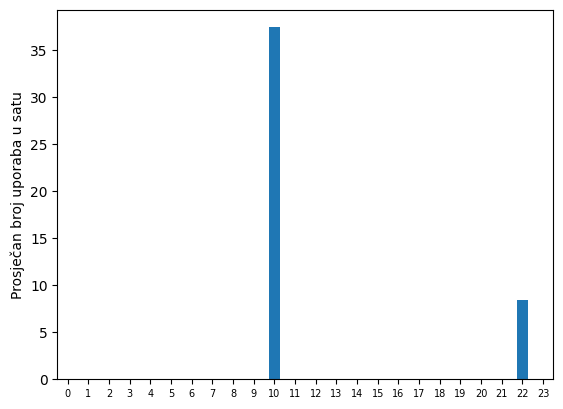

In [2042]:
_ = plot_hourly_changes_bar(hourly.loc[station], changes_type = "out")

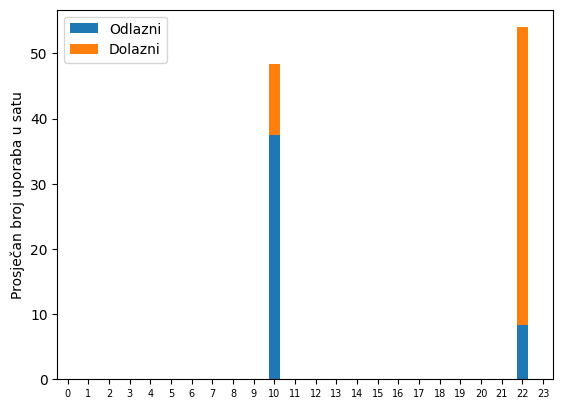

In [2043]:
_ = plot_hourly_changes_bar(hourly.loc[station], changes_type = "in/out")

## Usage by day of week

In [2044]:
daily = create_weekday_df(bike_data)
daily.head()

changes  incoming  outgoing
uid       wday                             
556632908 0         2.0       1.0       1.0
          1         5.0       3.0       2.0
          2         4.0       2.0       2.0
          3         5.0       2.0       3.0
          4         6.0       5.0       1.0

In [2045]:
daily.groupby(["wday"]).sum()

,changes,incoming,outgoing
wday,,,
0,1450.0,768.0,682.0
1,2785.0,1386.0,1399.0
2,2860.0,1428.0,1432.0
3,2961.0,1479.0,1482.0
4,2950.0,1459.0,1491.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0


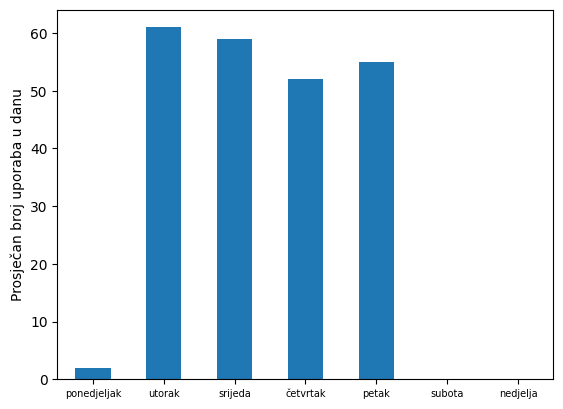

In [2046]:
daily_plot = plot_weekday_bar(daily.loc[station])

'\n    \n    '
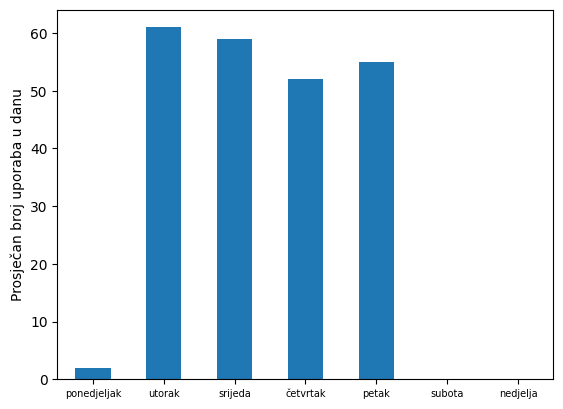

In [2047]:
stringify_plot(daily_plot.get_figure())

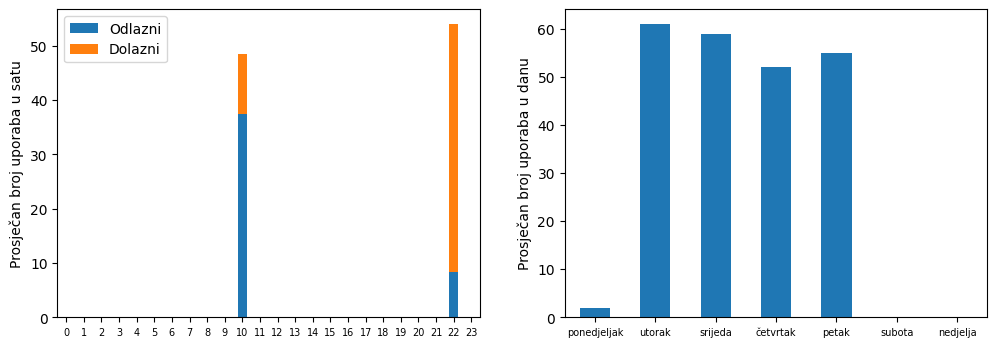

In [2048]:
combined_plot_daily_weekly(hourly.loc[station],daily.loc[station])[0]

In [2049]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

circles = populate_map_with_stations(m,
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Ukupno korištenja bicikala: ",
                               no_bins = 12)



In [2050]:
CREATE_IMAGES = False

# Add a popup to each Circle
# temporarily, the same image for all stations

# set to false to speed up when working on notebook
if CREATE_IMAGES:
    for i in range(len(circles)):
        circ = circles[i]

        station_uid = locations_changes["uid"].iloc[i]

        circ.add_child(folium.Popup(stringify_plot(
            combined_plot_daily_weekly(hourly.loc[station_uid], daily.loc[station_uid])[0]
            )))

    _ = [circ.add_to(m) for circ in circles]

In [2051]:
m

## Population
How many bikes at certain times vs. number of bike racks

In [2052]:
# Info o broju bicikala naspram broju mjesta u svakom trenutku
population_data = create_population_columns(locations, bike_data)
population_data.tail()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop
1656,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0,22,2025-11-14,4,11,1.1
1657,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0,22,2025-11-14,4,10,1.0
1658,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0,22,2025-11-14,4,9,0.9
1659,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0,22,2025-11-14,4,25,2.5
1660,587422590,2025-11-14 22:09:47,[],2025-11-14 10:14:47,[],0.0,0.0,0.0,22,2025-11-14,4,0,0.0


In [2053]:
# calculate occurences of interesting thresholds
population_data["out_of_bikes"] = population_data["population_prop"] == 0
population_data["low_on_bikes"] = population_data["population_prop"] <= 0.10

population_data["over_bike_capacity"] = population_data["population_prop"] > 1
population_data["greatly_over_bike_capacity"] = population_data["population_prop"] >= 1.2

population_data.tail()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
1656,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0,22,2025-11-14,4,11,1.1,False,False,True,False
1657,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0,22,2025-11-14,4,10,1.0,False,False,False,False
1658,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0,22,2025-11-14,4,9,0.9,False,False,False,False
1659,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0,22,2025-11-14,4,25,2.5,False,False,True,True
1660,587422590,2025-11-14 22:09:47,[],2025-11-14 10:14:47,[],0.0,0.0,0.0,22,2025-11-14,4,0,0.0,True,True,False,False


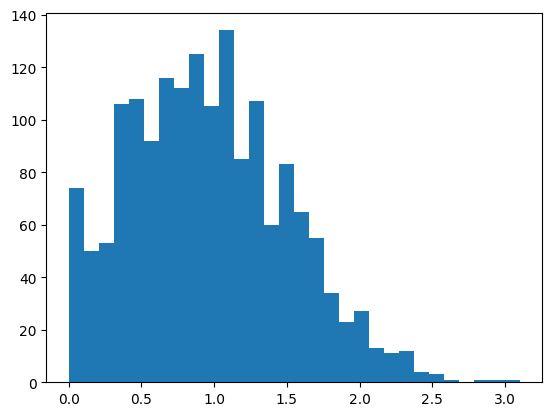

In [2054]:
_ = plt.hist(population_data["population_prop"], bins = 30)

In [2055]:
# For each DAY, count no. of each occurence for each station
df = population_data

df["date"] = df["time"].dt.date

daily = df.groupby(["uid", "date"]).agg({
    "out_of_bikes": "sum",
    "low_on_bikes": "sum",
    "over_bike_capacity": "sum",
    "greatly_over_bike_capacity": "sum"
})

daily


out_of_bikes  low_on_bikes  over_bike_capacity  \
uid       date                                                         
556632908 2025-11-10             0             0                   0   
          2025-11-11             0             0                   0   
          2025-11-12             0             0                   0   
          2025-11-13             0             0                   0   
          2025-11-14             0             0                   1   
...                            ...           ...                 ...   
586273004 2025-11-11             0             0                   1   
          2025-11-12             0             0                   3   
          2025-11-13             0             0                   2   
          2025-11-14             0             0                   2   
587422590 2025-11-14             1             1                   0   

                      greatly_over_bike_capacity  
uid       date                                    
556632908 2025-11-10                           0  
          2025-11-11                           0  
          2025-11-12                           0  
          2025-11-13                           0  
          2025-11-14                           0  
...                                          ...  
586273004 2025-11-11                           1  
          2025-11-12                           1  
          2025-11-13                           1  
          2025-11-14                           2  
587422590 2025-11-14                           0  

[831 rows x 4 columns]

In [2056]:
daily.index.get_level_values("uid").unique()

Index(['556632908', '556633495', '556634009', '556637365', '556689563',
       '556690758', '556693399', '556693838', '556694282', '556694696',
       ...
       '585912425', '585912526', '585912719', '585912890', '585913527',
       '585913605', '585913702', '586256300', '586273004', '587422590'],
      dtype='object', name='uid', length=168)

In [2057]:
daily.groupby("uid").agg({
    "out_of_bikes": "mean",
    "low_on_bikes": "mean",
    "over_bike_capacity": "mean",
    "greatly_over_bike_capacity": "mean"
}).reset_index()

,uid,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,0.0,0.0,0.2,0.0
1,556633495,0.0,0.0,0.0,0.0
2,556634009,0.0,0.0,0.6,0.6
3,556637365,0.0,0.0,0.8,0.4
4,556689563,0.0,0.0,0.4,0.0
...,...,...,...,...,...
163,585913605,0.4,0.6,0.6,0.4
164,585913702,0.0,0.0,0.6,0.4
165,586256300,0.0,0.0,0.0,0.0
166,586273004,0.0,0.0,1.6,1.0


In [2058]:
locations["uid"]

0      556632908
1      556633495
2      556634009
3      556637365
4      556689563
         ...    
163    585913605
164    585913702
165    586256300
166    586273004
167    587422590
Name: uid, Length: 168, dtype: object

In [2059]:
# Calculate daily average for each station, with other station info


station_population = daily.groupby("uid").agg({
    "out_of_bikes": "mean",
    "low_on_bikes": "mean",
    "over_bike_capacity": "mean",
    "greatly_over_bike_capacity": "mean"
}).reset_index()


station_population

,uid,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,0.0,0.0,0.2,0.0
1,556633495,0.0,0.0,0.0,0.0
2,556634009,0.0,0.0,0.6,0.6
3,556637365,0.0,0.0,0.8,0.4
4,556689563,0.0,0.0,0.4,0.0
...,...,...,...,...,...
163,585913605,0.4,0.6,0.6,0.4
164,585913702,0.0,0.0,0.6,0.4
165,586256300,0.0,0.0,0.0,0.0
166,586273004,0.0,0.0,1.6,1.0


In [2060]:
station_population = pd.merge(locations, station_population)
station_population

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8,0.0,0.0,0.2,0.0
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12,0.0,0.0,0.0,0.0
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10,0.0,0.0,0.6,0.6
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20,0.0,0.0,0.8,0.4
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,0.0,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...
163,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10,0.4,0.6,0.6,0.4
164,585913702,KORANSKA UL.,45.802365,15.968013,10,0.0,0.0,0.6,0.4
165,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10,0.0,0.0,0.0,0.0
166,586273004,UL. V. VARIĆAKA 12,45.765589,15.988426,10,0.0,0.0,1.6,1.0


In [2061]:
station_population.sort_values("out_of_bikes", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
167,587422590,MLADOST,45.783761,15.944574,10,1.0,1.0,0.0,0.0
62,579364575,KBC REBRO,45.823120,16.008103,16,0.8,1.6,0.0,0.0
82,579368063,UL. GRADA VUKOVARA 52,45.799220,15.963448,10,0.8,1.0,0.0,0.0
160,585912719,JUKIĆEVA UL. - UL. ISIDORA KRŠNJAVOG,45.807725,15.962247,10,0.6,0.6,0.0,0.0
33,556911042,NACIONALNA I SVEUČILIŠNA KNJIŽNICA,45.797292,15.978450,10,0.4,0.4,0.2,0.2


In [2062]:
station_population.sort_values("low_on_bikes", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
62,579364575,KBC REBRO,45.823120,16.008103,16,0.8,1.6,0.0,0.0
82,579368063,UL. GRADA VUKOVARA 52,45.799220,15.963448,10,0.8,1.0,0.0,0.0
167,587422590,MLADOST,45.783761,15.944574,10,1.0,1.0,0.0,0.0
150,584419419,ŠETALIŠTE JURIJA GAGARINA,45.796759,15.961126,10,0.0,0.8,0.0,0.0
53,579362036,SREDNJA ŠKOLA JELKOVEC,45.811709,16.106626,10,0.2,0.6,0.0,0.0


In [2063]:
station_population.sort_values("over_bike_capacity", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
78,579367560,OSNOVNA ŠKOLA MALEŠNICA,45.808108,15.901237,10,0.0,0.0,2.0,2.0
80,579367813,UL. GRADA CHICAGA,45.786318,16.005994,10,0.0,0.0,2.0,1.4
86,579368650,KLIZALIŠTE VELESAJAM,45.783103,15.970881,8,0.0,0.0,2.0,2.0
63,579364727,UL. JORDANOVAC,45.819349,16.006375,8,0.0,0.0,2.0,1.8
56,579363717,EUROSPIN DUBRAVA,45.818098,16.043003,10,0.0,0.0,2.0,2.0


In [2064]:
station_population.sort_values("greatly_over_bike_capacity", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
140,583392895,UL. S.ALIĆA - UL. S.DRAGANIĆA,45.807223,15.896030,6,0.0,0.0,2.0,2.0
86,579368650,KLIZALIŠTE VELESAJAM,45.783103,15.970881,8,0.0,0.0,2.0,2.0
99,583377742,TRNSKO 34B,45.773068,15.965179,10,0.0,0.0,2.0,2.0
101,583378327,BARUTANSKI BREG - BUKOVAČKA CESTA,45.825087,16.010814,10,0.0,0.0,2.0,2.0
78,579367560,OSNOVNA ŠKOLA MALEŠNICA,45.808108,15.901237,10,0.0,0.0,2.0,2.0


In [2065]:
station_population.sort_values("low_on_bikes", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
62,579364575,KBC REBRO,45.823120,16.008103,16,0.8,1.6,0.0,0.0
82,579368063,UL. GRADA VUKOVARA 52,45.799220,15.963448,10,0.8,1.0,0.0,0.0
167,587422590,MLADOST,45.783761,15.944574,10,1.0,1.0,0.0,0.0
150,584419419,ŠETALIŠTE JURIJA GAGARINA,45.796759,15.961126,10,0.0,0.8,0.0,0.0
53,579362036,SREDNJA ŠKOLA JELKOVEC,45.811709,16.106626,10,0.2,0.6,0.0,0.0


In [2066]:
create_hourly_df(population_data.drop(["wday", "no_bikes"], axis = 1))

changes  incoming  outgoing  population_prop  out_of_bikes  \
uid       hour                                                               
556632908 0         0.0       0.0       0.0              0.0           0.0   
          1         0.0       0.0       0.0              0.0           0.0   
          2         0.0       0.0       0.0              0.0           0.0   
          3         0.0       0.0       0.0              0.0           0.0   
          4         0.0       0.0       0.0              0.0           0.0   
...                 ...       ...       ...              ...           ...   
587422590 19        0.0       0.0       0.0              0.0           0.0   
          20        0.0       0.0       0.0              0.0           0.0   
          21        0.0       0.0       0.0              0.0           0.0   
          22        0.0       0.0       0.0              0.0           1.0   
          23        0.0       0.0       0.0              0.0           0.0   

                low_on_bikes  over_bike_capacity  greatly_over_bike_capacity  
uid       hour                                                                
556632908 0              0.0                 0.0                         0.0  
          1              0.0                 0.0                         0.0  
          2              0.0                 0.0                         0.0  
          3              0.0                 0.0                         0.0  
          4              0.0                 0.0                         0.0  
...                      ...                 ...                         ...  
587422590 19             0.0                 0.0                         0.0  
          20             0.0                 0.0                         0.0  
          21             0.0                 0.0                         0.0  
          22             1.0                 0.0                         0.0  
          23             0.0                 0.0                         0.0  

[4032 rows x 8 columns]

In [2067]:
all_stations_pop = population_data.groupby(["time"]).mean(["population_prop"])
all_stations_pop.head()

,changes,incoming,outgoing,hour,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
time,,,,,,,,,,,
2025-11-10 22:02:43,8.787879,4.654545,4.133333,22.0,0.0,11.484848,1.001435,0.042424,0.072727,0.472727,0.375758
2025-11-11 10:06:29,6.290909,2.975758,3.315152,10.0,1.0,11.145455,0.966213,0.024242,0.024242,0.448485,0.357576
2025-11-11 22:09:35,10.587879,5.424242,5.163636,22.0,1.0,11.406061,0.986732,0.018182,0.042424,0.424242,0.327273
2025-11-12 10:02:54,5.867470,2.807229,3.060241,10.0,2.0,11.120482,0.965983,0.006024,0.024096,0.421687,0.319277
2025-11-12 10:30:11,0.867470,0.493976,0.373494,10.0,2.0,11.240964,0.978611,0.006024,0.018072,0.409639,0.331325


{'whiskers': [<matplotlib.lines.Line2D at 0x1fb4e651a90>,
 'caps': [<matplotlib.lines.Line2D at 0x1fb4e651d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fb4e651950>],
 'medians': [<matplotlib.lines.Line2D at 0x1fb4e651f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fb4e6520d0>],
 'means': []}

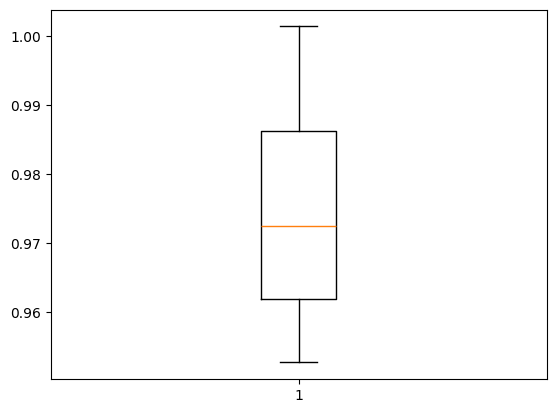

In [2068]:
plt.boxplot(all_stations_pop["population_prop"])

In [2069]:
tkt_uid = locations[locations["name"] == "FILOZOFSKI FAKULTET"]["uid"].to_list()[0]

tkt_population = population_data[population_data["uid"] == tkt_uid]

tkt_population.head()


,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
58,579364165,2025-11-10 22:02:43,[],2025-11-10 16:11:31,"[800432, 800326, 800319, 800316, 800289, 80023...",41.0,0.0,41.0,22,2025-11-10,0,0,0.00,True,True,False,False
223,579364165,2025-11-11 10:06:29,"[800455, 800375, 800274, 800225, 800221, 80001...",2025-11-10 22:02:43,[],20.0,20.0,0.0,10,2025-11-11,1,20,1.00,False,False,False,False
388,579364165,2025-11-11 22:09:35,[801077],2025-11-11 10:06:29,"[800455, 800375, 800274, 800225, 800221, 80001...",21.0,1.0,20.0,22,2025-11-11,1,1,0.05,False,True,False,False
553,579364165,2025-11-12 10:02:54,"[800401, 800318, 800317, 800097, 801922, 80184...",2025-11-11 22:09:35,[801077],22.0,21.0,1.0,10,2025-11-12,2,21,1.05,False,False,True,False
719,579364165,2025-11-12 10:30:11,"[800318, 800097, 801922, 801849, 801825, 80178...",2025-11-12 10:02:54,"[800401, 800318, 800317, 800097, 801922, 80184...",9.0,5.0,4.0,10,2025-11-12,2,22,1.10,False,False,True,False


{'whiskers': [<matplotlib.lines.Line2D at 0x1fb4e6c4550>,
 'caps': [<matplotlib.lines.Line2D at 0x1fb4e6c47d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fb4e6c4410>],
 'medians': [<matplotlib.lines.Line2D at 0x1fb4e6c4a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fb4e6c4b90>],
 'means': []}

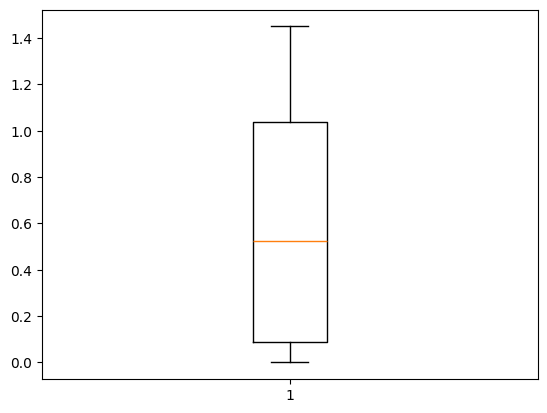

In [2070]:
plt.boxplot(tkt_population["population_prop"])

Za interpretaciju:  
ispod crte u boxu je 50% rezultata, od crte do donjeg kraja boxa je 25% rezultata.

Idealna distribucija je gdje je medijan negdje ispod 100% - uvijek je dostupan velik broj bicikala, kao i par mjesta za ostaviti bickle.
Ako se kutija proteže znatno iznad 1.0, znači da je česta situacija gdje je na postaji ostavljeno više bicikala od dostupnog broja mjesta.
Povećanje broja dostupnih mjesta bi popravilo tu situaciju.


-> dodati postotak opaženih vremena u kojima je prisutno 0 bicikala - prevelika navala, netko tko bi htio koristiti bajs ne može!
--> bolje: dodati tablicu s deset postaja u kojima je dnevna incidencija 0 dostupnih bicikala najveća. Konkretan broj opaženih situacija ovisi o učestalosti mjerenja, ali postaje gdje je taj broj najveći su one gdje je to najčešći problem, neovisno o učestalosti mjerenja.


In [2071]:
# boxplot paralelno za 3 postaje koje imaju najviši, pa 3 s najnižim mean population -- za sve vremenske točke, bez agregiranja

In [2072]:
stations_pop = population_data.groupby(["uid"]).median(["population_prop"]).sort_values("population_prop", ascending = False)

pop_high = stations_pop.head(3)
pop_low = stations_pop.tail(3)

pop_high

,changes,incoming,outgoing,hour,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
uid,,,,,,,,,,,
579359574,5.5,3.5,3.0,16.0,2.0,21.0,2.100000,0.0,0.0,1.0,1.0
583392895,3.0,2.5,1.0,16.0,2.0,11.5,1.916667,0.0,0.0,1.0,1.0
583376832,7.0,2.5,3.0,16.0,2.0,18.5,1.850000,0.0,0.0,1.0,1.0


In [2073]:
pop_low

,changes,incoming,outgoing,hour,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
uid,,,,,,,,,,,
579368063,9.0,1.5,2.5,16.0,2.0,1.5,0.1500,0.0,0.5,0.0,0.0
579364575,1.5,0.0,1.0,16.0,2.0,1.0,0.0625,0.0,1.0,0.0,0.0
587422590,0.0,0.0,0.0,22.0,4.0,0.0,0.0000,1.0,1.0,0.0,0.0


In [2074]:
uid_high = pop_high.index.to_list()
uid_low = pop_low.index.to_list()
uids = uid_high + uid_low
uids

['579359574', '583392895', '583376832', '579368063', '579364575', '587422590']

In [2075]:
plot_data = population_data[population_data["uid"].isin(uids)].merge(locations, on = "uid")

# proporcije u postotke
plot_data["population_prop"] *= 100
plot_data.head()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,...,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity,name,lat,lng,no_racks
0,579359574,2025-11-10 22:02:43,"[800487, 800453, 800408, 800388, 800263, 80022...",2025-11-10 16:11:31,"[800487, 800453, 800408, 800388, 800224, 80014...",7.0,6.0,1.0,22,2025-11-10,...,22,220.000000,False,False,True,True,KULTURNI CENTAR DUBRAVA,45.829502,16.054064,10
1,579364575,2025-11-10 22:02:43,[],2025-11-10 16:11:31,"[801973, 801970, 801946, 801926, 801865]",5.0,0.0,5.0,22,2025-11-10,...,0,0.000000,True,True,False,False,KBC REBRO,45.823120,16.008103,16
2,579368063,2025-11-10 22:02:43,[801377],2025-11-10 16:11:31,"[800253, 800193, 801983, 801976, 801944, 80192...",13.0,1.0,12.0,22,2025-11-10,...,1,10.000000,False,True,False,False,UL. GRADA VUKOVARA 52,45.799220,15.963448,10
3,583376832,2025-11-10 22:02:43,"[800474, 800364, 800074, 800073, 800058, 80002...",2025-11-10 16:11:31,"[800474, 800364, 800208, 800073, 800058, 80179...",9.0,4.0,5.0,22,2025-11-10,...,16,160.000000,False,False,True,True,TRG 101. BRIGADE,45.798670,15.905173,10
4,583392895,2025-11-10 22:02:43,"[800374, 800341, 801623, 801591, 801442, 80133...",2025-11-10 16:11:31,"[800374, 800341, 801623, 801332, 801266, 80119...",4.0,4.0,0.0,22,2025-11-10,...,11,183.333333,False,False,True,True,UL. S.ALIĆA - UL. S.DRAGANIĆA,45.807223,15.896030,6


In [2076]:
uids

['579359574', '583392895', '583376832', '579368063', '579364575', '587422590']

In [2077]:
order_names = locations[locations["uid"].isin(uids)]

order_names = order_names.set_index("uid").reindex(uids)["name"].to_list()
order_names

['KULTURNI CENTAR DUBRAVA',
 'UL. S.ALIĆA - UL. S.DRAGANIĆA',
 'TRG 101. BRIGADE',
 'UL. GRADA VUKOVARA 52',
 'KBC REBRO',
 'MLADOST']

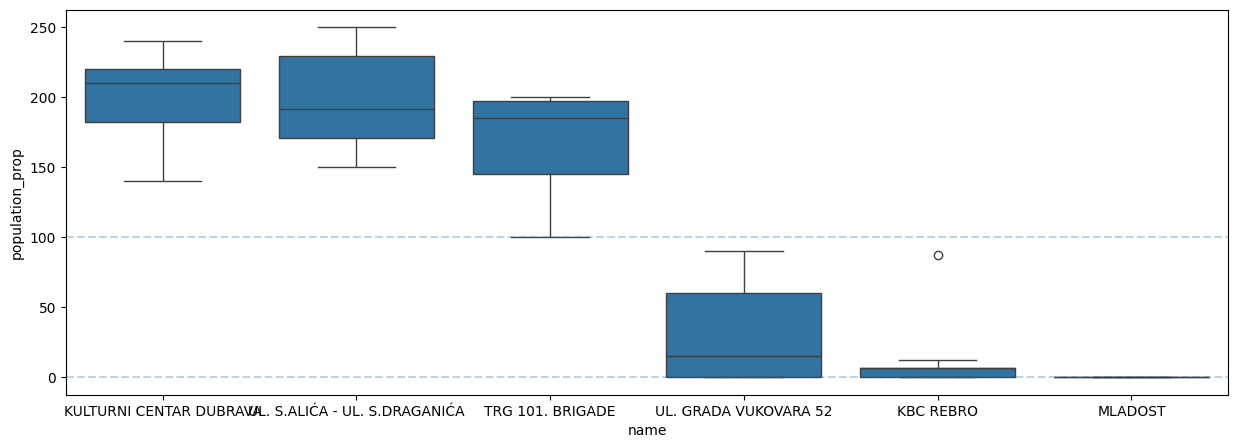

In [2078]:
plt.figure(figsize=(15,5))

ax = sns.boxplot(data = plot_data, y = "population_prop", x = "name", order = order_names)

# referentne crte za 0% i 100%
_ = ax.axhline(0, ls="--", alpha = 0.3)
_ = ax.axhline(100, ls="--", alpha = 0.3)

In [2079]:
population_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,2025-11-10 22:02:43,"[800463, 800020, 801638, 801088, 800886]",2025-11-10 16:11:31,"[800463, 800020, 801638, 801088, 801072]",2.0,1.0,1.0,22,2025-11-10,0,5,0.625,False,False,False,False
1,556633495,2025-11-10 22:02:43,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-10 16:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",2.0,0.0,2.0,22,2025-11-10,0,9,0.750,False,False,False,False
2,556634009,2025-11-10 22:02:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-10 16:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",6.0,5.0,1.0,22,2025-11-10,0,18,1.800,False,False,True,True
3,556637365,2025-11-10 22:02:43,"[800428, 800345, 801920, 801915, 801881, 80174...",2025-11-10 16:11:31,"[801920, 801915, 800748, 800640, 800625]",16.0,14.0,2.0,22,2025-11-10,0,17,0.850,False,False,False,False
4,556689563,2025-11-10 22:02:43,"[801846, 801666, 801548, 801347, 801283, 80102...",2025-11-10 16:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",9.0,4.0,5.0,22,2025-11-10,0,11,0.550,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,585913605,2025-11-14 22:09:47,"[800420, 801796, 801587, 801486, 801278, 80113...",2025-11-14 10:14:47,"[800395, 801796, 801792, 801555, 801486, 80127...",7.0,3.0,4.0,22,2025-11-14,4,11,1.100,False,False,True,False
1657,585913702,2025-11-14 22:09:47,"[800401, 800387, 800169, 801866, 801789, 80150...",2025-11-14 10:14:47,"[800401, 800387, 800356, 800169, 801830, 80178...",6.0,3.0,3.0,22,2025-11-14,4,10,1.000,False,False,False,False
1658,586256300,2025-11-14 22:09:47,"[800452, 800144, 801889, 801867, 801122, 80106...",2025-11-14 10:14:47,"[800144, 801889, 801867, 801210, 801066, 80095...",3.0,2.0,1.0,22,2025-11-14,4,9,0.900,False,False,False,False
1659,586273004,2025-11-14 22:09:47,"[800199, 800119, 800061, 800044, 800034, 80195...",2025-11-14 10:14:47,"[800119, 801950, 801938, 801935, 801924, 80191...",12.0,10.0,2.0,22,2025-11-14,4,25,2.500,False,False,True,True


In [2080]:
top_5_stations = get_population_extremes(population_data, n_top = 5, n_bottom = 0)
top_5_stations

['579359574', '583392895', '583376832', '579368650', '583385935']

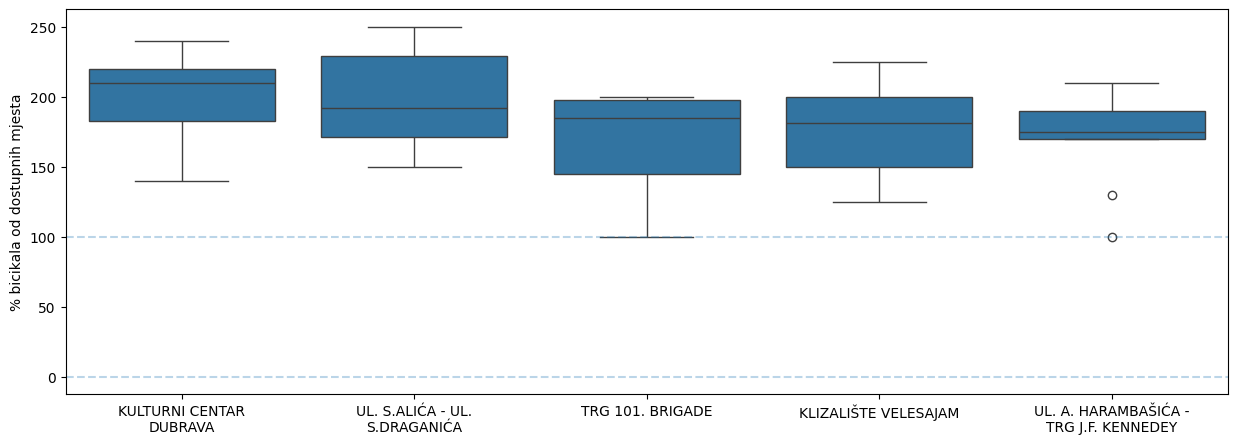

In [2081]:
plt.figure(figsize=(15,5))
_ = station_population_boxplots(population_data, locations, top_5_stations)

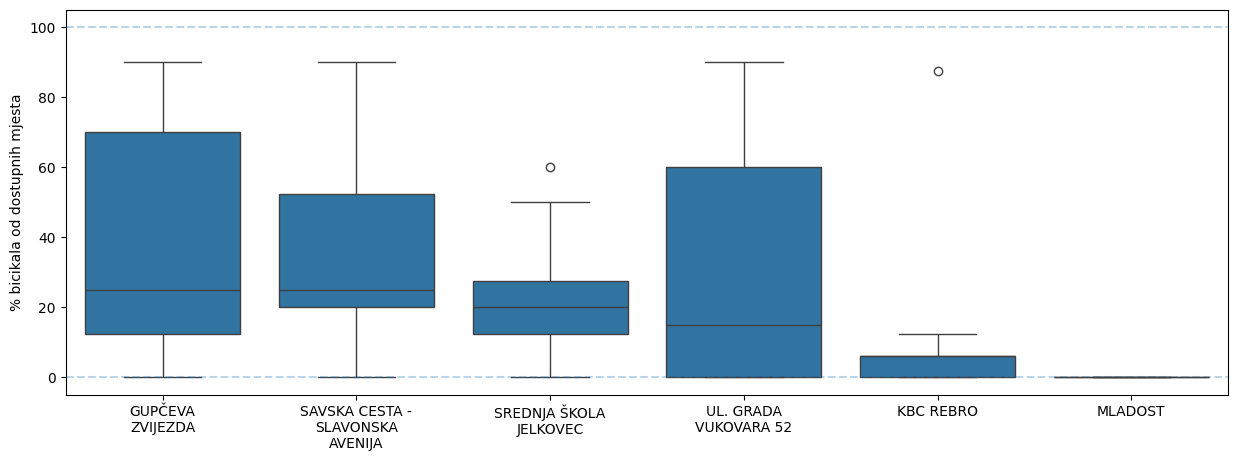

In [2086]:
bottom_6_stations = get_population_extremes(population_data, n_top = 0, n_bottom = 6)
plt.figure(figsize=(15,5))
_ = station_population_boxplots(population_data, locations, bottom_6_stations, text_wrap_chars = 15)